### <p style="text-align: center;">Community Segmentation</p>
# <p style="text-align: center;">Country Clustering</p>
#### <p style="text-align: center;">Jeffrey D Nelson and David N Campbell</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set seaborn defaults
sns.set()

df = pd.read_csv(r'data/country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [2]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


## Data Preprocessing

Before we can train any models, we must preprocess the data. First, we handle non-numeric features.

In this case, there is only one non-numeric feature, `country`. This was found using `df.select_dtypes(exclude=np.number).columns`. This feature is irrelevant, so we just drop it.

In [3]:
labels = df['country']
df = df.drop(columns=['country'])

Luckily, in this dataset there are no missing values, so there is no need to substitute or guess the missing data! 

### Scaling

After a few iterations, we realized that our clustering was performing poorly due to outliers in the dataset.  To scale this dataset we just used a standard scaler.

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

### Feature Correlations

The correlation between features is an important relationship to explore, and a great way to visualize these correlations is using a heat map, which seaborn makes simple.

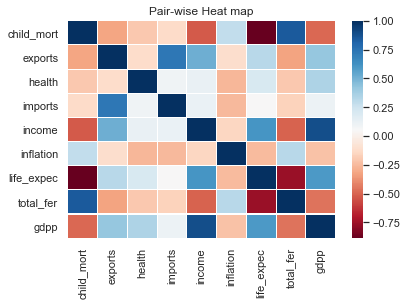

In [5]:
import seaborn as sns

g = sns.heatmap(df_scaled.corr(), annot=False, linewidths=0.1, vmax=1.0, linecolor='white', cmap=plt.cm.RdBu)
g.set_title("Pair-wise Heat map")
plt.show()

From the chart up, there are many interesting correlations, but some of the strongest are listed below:
- life expecency is negatively correlated with child mortality.  This makes sense, seeing as more children dying would descrese the life expectency
- exports are strongly correlated with imports.  This makes sense indicating that a country's econony scales with imports and exports together. 
- income and gdp are highly correlated.  This makes sense because the more individuals have to spend on average, the more goods that are produced to meet that demand. 
-child mortality is negatively correlated with income.  This makes sense because country's that can't pay for child healthcare intuitively indicates children would die more often, unfortately.

## PCA

Since there are so many features, we use PCA to decompose to the subset that captures the majority of the variance in the dataset.

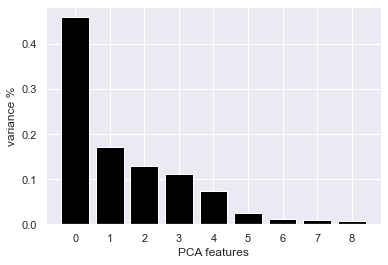

In [6]:
from sklearn.decomposition import PCA

num_features = len(df_scaled.columns)

pca = PCA(n_components=num_features)
principal_components = pca.fit_transform(df_scaled)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

it is recommended that using PCA we choose as many features are needed to explain at least 80% of the variance.  In the plot above, one can see that we will need the first 3 principle components to explain that amount of variance in this dataset.

In [7]:
pca = PCA(n_components=3)
df_scaled_pca = pca.fit_transform(df_scaled)

pc_df = pd.DataFrame(pca.components_.T, columns=['PC-1', 'PC-2', 'PC-3'], index=df_scaled.columns)
pc_df

,PC-1,PC-2,PC-3
child_mort,-0.419519,0.192884,-0.029544
exports,0.283897,0.613163,0.144761
health,0.150838,-0.243087,-0.596632
imports,0.161482,0.671821,-0.299927
income,0.398441,0.022536,0.301548
inflation,-0.193173,-0.008404,0.642520
life_expec,0.425839,-0.222707,0.113919
total_fer,-0.403729,0.155233,0.019549
gdpp,0.392645,-0.046022,0.122977


## K-Means

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
clusters = [ i for i in range(2, 15) ]

for i in clusters:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_scaled_pca)
    score = silhouette_score(df_scaled_pca, kmeans.predict(df_scaled_pca))
    print("Silhouette score for {num} clusters: {score}".format(num=i, score=score))
    silhouette_scores.append(score)

Silhouette score for 2 clusters: 0.3486469452367987
Silhouette score for 3 clusters: 0.37307557614406556
Silhouette score for 4 clusters: 0.28690631542673184
Silhouette score for 5 clusters: 0.2902046922169579
Silhouette score for 6 clusters: 0.3004382769046051
Silhouette score for 7 clusters: 0.2992843295168262
Silhouette score for 8 clusters: 0.29979787456703405
Silhouette score for 9 clusters: 0.3133084466603223
Silhouette score for 10 clusters: 0.3155229111035745
Silhouette score for 11 clusters: 0.29933869886111236
Silhouette score for 12 clusters: 0.3048385917865631
Silhouette score for 13 clusters: 0.29801559019262797
Silhouette score for 14 clusters: 0.2771921592982205


In [30]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_scaled_pca)
kmeans.cluster_centers_

array([[ 1.32566954, -0.39605612, -0.04256656],
       [-1.79153684,  0.25268766,  0.0420464 ],
       [ 5.46022462,  5.43247334,  0.21164795]])

In [31]:
# ColumnTransformer has no inverse transform...
inverse_array = pd.DataFrame(pca.inverse_transform(kmeans.cluster_centers_), columns=df.columns)
inverse_center_df = pd.DataFrame(scaler.inverse_transform(inverse_array), columns=df.columns)
inverse_center_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,12.887573,44.589277,7.696515,45.943092,26878.599609,4.829807,76.300099,2.046116,22713.382064
1,70.399542,31.609504,5.838712,43.700467,3777.986201,11.691470,63.334874,4.100084,-8.307161
2,-11.953212,175.346849,5.108910,154.731883,62539.556572,-2.382373,80.658548,0.899812,48048.677805


In [32]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Describe more here....

In [34]:
val = kmeans.predict(df_scaled_pca)
print("Cluster 0 Occurences: ", np.count_nonzero(val == 0))
print("Cluster 1 Occurences: ", np.count_nonzero(val == 1))
print("Cluster 2 Occurences: ", np.count_nonzero(val == 2))

Cluster 0 Occurences:  89
Cluster 1 Occurences:  75
Cluster 2 Occurences:  3


In [35]:
print("Countries belonging to Cluster 0:")
for i in range(len(df_scaled_pca)):
    if (val[i] == 0):
        print(labels[i])

Countries belonging to Cluster 0:
Albania
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Barbados
Belarus
Belgium
Belize
Bosnia and Herzegovina
Brazil
Brunei
Bulgaria
Canada
Chile
China
Colombia
Costa Rica
Croatia
Cyprus
Czech Republic
Denmark
Dominican Republic
Ecuador
El Salvador
Estonia
Finland
France
Georgia
Germany
Greece
Grenada
Hungary
Iceland
Iran
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kuwait
Latvia
Lebanon
Libya
Lithuania
Macedonia, FYR
Malaysia
Maldives
Mauritius
Moldova
Montenegro
Morocco
Netherlands
New Zealand
Norway
Oman
Panama
Paraguay
Peru
Poland
Portugal
Qatar
Romania
Russia
Saudi Arabia
Serbia
Seychelles
Slovak Republic
Slovenia
South Korea
Spain
St. Vincent and the Grenadines
Suriname
Sweden
Switzerland
Thailand
Tunisia
Turkey
Ukraine
United Arab Emirates
United Kingdom
United States
Uruguay
Vietnam


In [36]:
print("Countries belonging to Cluster 1:")
for i in range(len(df_scaled_pca)):
    if (val[i] == 1):
        print(labels[i])

Countries belonging to Cluster 1:
Afghanistan
Algeria
Angola
Bangladesh
Benin
Bhutan
Bolivia
Botswana
Burkina Faso
Burundi
Cambodia
Cameroon
Cape Verde
Central African Republic
Chad
Comoros
Congo, Dem. Rep.
Congo, Rep.
Cote d'Ivoire
Egypt
Equatorial Guinea
Eritrea
Fiji
Gabon
Gambia
Ghana
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
India
Indonesia
Iraq
Kazakhstan
Kenya
Kiribati
Kyrgyz Republic
Lao
Lesotho
Liberia
Madagascar
Malawi
Mali
Mauritania
Micronesia, Fed. Sts.
Mongolia
Mozambique
Myanmar
Namibia
Nepal
Niger
Nigeria
Pakistan
Philippines
Rwanda
Samoa
Senegal
Sierra Leone
Solomon Islands
South Africa
Sri Lanka
Sudan
Tajikistan
Tanzania
Timor-Leste
Togo
Tonga
Turkmenistan
Uganda
Uzbekistan
Vanuatu
Venezuela
Yemen
Zambia


In [37]:
print("Countries belonging to Cluster 2:")
for i in range(len(df_scaled_pca)):
    if (val[i] == 2):
        print(labels[i])

Countries belonging to Cluster 2:
Luxembourg
Malta
Singapore


You can see from the data above, the data is easily broken into countries that are rich, with thriving economies, and countries that are poor that have less thriving economies.  It also shows that countries with better economies have higher life expectency and lower child mortality rate.

In some cases, we may want to see which countries are extremely poor and need more aid than others.  Even though the silhouette score is lower, let us experiment using five 5 clusters to see if we can further find even poorer nations.

## Kmeans (Again) - More Clusters

In [41]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(df_scaled_pca)
kmeans.cluster_centers_

array([[ 0.36869093,  0.43796371, -0.51777987],
       [ 2.34665779, -0.80010295,  0.02217812],
       [ 5.46022462,  5.43247334,  0.21164795],
       [-2.62487021,  0.43953443, -0.04502891],
       [-0.36900511, -0.70742552,  0.6962666 ]])

In [42]:
# ColumnTransformer has no inverse transform...
inverse_array = pd.DataFrame(pca.inverse_transform(kmeans.cluster_centers_), columns=df.columns)
inverse_center_df = pd.DataFrame(scaler.inverse_transform(inverse_array), columns=df.columns)
inverse_center_df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,36.062648,49.260351,7.522449,59.177544,17156.915473,3.486284,70.559953,2.810637,14077.633124
1,-7.544984,45.996248,8.281462,42.901975,34897.713595,3.225435,81.018291,1.331219,30524.368610
2,-11.953212,175.346849,5.108910,154.731883,62539.556572,-2.382373,80.658548,0.899812,48048.677805
3,86.008765,27.930411,5.512364,44.112607,-3027.542005,12.781831,59.731547,4.649084,-6340.369801
4,38.180944,29.145762,5.996548,28.940016,18047.818684,13.310514,71.262608,3.027616,12476.147751


In [45]:
val = kmeans.predict(df_scaled_pca)
print("Cluster 0 Occurences: ", np.count_nonzero(val == 0))
print("Cluster 1 Occurences: ", np.count_nonzero(val == 1))
print("Cluster 2 Occurences: ", np.count_nonzero(val == 2))
print("Cluster 3 Occurences: ", np.count_nonzero(val == 3))
print("Cluster 4 Occurences: ", np.count_nonzero(val == 4))

Cluster 0 Occurences:  49
Cluster 1 Occurences:  37
Cluster 2 Occurences:  3
Cluster 3 Occurences:  41
Cluster 4 Occurences:  37


In [46]:
print("Countries belonging to Cluster 0:")
for i in range(len(df_scaled_pca)):
    if (val[i] == 0):
        print(labels[i])

Countries belonging to Cluster 0:
Albania
Antigua and Barbuda
Barbados
Belarus
Belize
Bhutan
Bosnia and Herzegovina
Botswana
Bulgaria
Cambodia
Cape Verde
El Salvador
Estonia
Fiji
Georgia
Grenada
Guyana
Hungary
Jordan
Kiribati
Kyrgyz Republic
Latvia
Lebanon
Lithuania
Macedonia, FYR
Malaysia
Maldives
Mauritius
Micronesia, Fed. Sts.
Moldova
Montenegro
Morocco
Namibia
Panama
Paraguay
Samoa
Serbia
Seychelles
Slovak Republic
Solomon Islands
St. Vincent and the Grenadines
Suriname
Thailand
Tonga
Tunisia
Turkmenistan
Ukraine
Vanuatu
Vietnam


In [47]:
print("Countries belonging to Cluster 1:")
for i in range(len(df_scaled_pca)):
    if (val[i] == 1):
        print(labels[i])

Countries belonging to Cluster 1:
Australia
Austria
Bahamas
Bahrain
Belgium
Brunei
Canada
Chile
Costa Rica
Croatia
Cyprus
Czech Republic
Denmark
Finland
France
Germany
Greece
Iceland
Ireland
Israel
Italy
Japan
Kuwait
Netherlands
New Zealand
Norway
Poland
Portugal
Qatar
Slovenia
South Korea
Spain
Sweden
Switzerland
United Arab Emirates
United Kingdom
United States


In [48]:
print("Countries belonging to Cluster 2:")
for i in range(len(df_scaled_pca)):
    if (val[i] == 2):
        print(labels[i])

Countries belonging to Cluster 2:
Luxembourg
Malta
Singapore


In [49]:
print("Countries belonging to Cluster 3:")
for i in range(len(df_scaled_pca)):
    if (val[i] == 3):
        print(labels[i])

Countries belonging to Cluster 3:
Afghanistan
Angola
Benin
Burkina Faso
Burundi
Cameroon
Central African Republic
Chad
Comoros
Congo, Dem. Rep.
Congo, Rep.
Cote d'Ivoire
Equatorial Guinea
Eritrea
Gambia
Ghana
Guinea
Guinea-Bissau
Haiti
Kenya
Lao
Lesotho
Liberia
Madagascar
Malawi
Mali
Mauritania
Mozambique
Niger
Nigeria
Pakistan
Rwanda
Senegal
Sierra Leone
Sudan
Tanzania
Timor-Leste
Togo
Uganda
Yemen
Zambia


In [50]:
print("Countries belonging to Cluster 4:")
for i in range(len(df_scaled_pca)):
    if (val[i] == 4):
        print(labels[i])

Countries belonging to Cluster 4:
Algeria
Argentina
Armenia
Azerbaijan
Bangladesh
Bolivia
Brazil
China
Colombia
Dominican Republic
Ecuador
Egypt
Gabon
Guatemala
India
Indonesia
Iran
Iraq
Jamaica
Kazakhstan
Libya
Mongolia
Myanmar
Nepal
Oman
Peru
Philippines
Romania
Russia
Saudi Arabia
South Africa
Sri Lanka
Tajikistan
Turkey
Uruguay
Uzbekistan
Venezuela


As you can see, from the data above, by choosing more clusters we have further found countries that are extremely poor and thus could benefit better from more aid.